In [1]:
import matplotlib.pyplot as plt
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="human", max_episode_steps=1000)

In [ ]:
env.reset()
a = 0
done = 0
while (not done or not trunc):
    a = not a
    obs, reward, done, trunc, info = env.step(a)

<frozen importlib._bootstrap>:491: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
/home/raphael/code/.venv/lib64/python3.14/site-packages/gymnasium/envs/classic_control/cartpole.py:214: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


In [3]:
env.close()

In [4]:
env = gym.make("CartPole-v1", render_mode="rgb_array", max_episode_steps=1000)

In [5]:
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [6]:
img = env.render()
img.shape

(400, 600, 3)

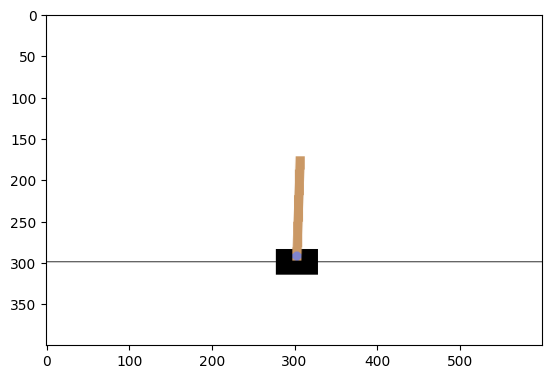

In [7]:

plt.imshow(img)

In [8]:
env.action_space # 0 - vänster, 1 - höger

Discrete(2)

In [9]:
def basic_policy(obs):
    angle = obs[2]
    if angle < 0:
        return 0
    else:
        return 1

In [10]:
#env = gym.make("CartPole-v1", render_mode="human", max_episode_steps=1000)
totals = []
for episode in range(500):
    total_rewards = 0
    obs, info = env.reset(seed=episode)
    trunc, done = False, False
    while (not done and not trunc):
        action = basic_policy(obs)
        obs, reward, done, trunc, info = env.step(action)                     
        total_rewards += reward        
    totals.append(total_rewards)
env.close()

In [11]:
import numpy as np
np.mean(totals), np.std(totals), min(totals), max(totals)

(np.float64(41.698), np.float64(8.389445512070509), 24.0, 63.0)

Låt oss använda ett neuralt nätverk som policy! På så sätt kan vi istället lära oss vilka inputs som är bäst för att hålla balansen.

In [12]:
import torch
import torch.nn as nn

class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(4,5), nn.ReLU(), nn.Linear(5,1))

    def forward(self, state):
        return self.net(state)

In [13]:
def choose_action(model, obs):
    state = torch.as_tensor(obs)
    logit = model(state)
    dist = torch.distributions.Bernoulli(logits=logit)
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return int(action.item()), log_prob

Ok! Men hur tränar vi nätverket?

<img src="../Data/credit_problems.png" height="480" widht="640" />

In [ ]:
def compute_returns(rewards, discount_factor):
    returns = rewards[:]
    for step in range(len(returns) - 1, 0, -1):
        returns[step-1] += returns[step] * discount_factor
    return torch.tensor(returns)

In [15]:
def run_episode(model, env, seed=None):    
    log_probs, rewards = [], []
    obs, info = env.reset(seed=seed)
    while True:
        action, log_prob = choose_action(model, obs)
        obs, reward, done, trunc, _ = env.step(action)
        log_probs.append(log_prob)
        rewards.append(reward)
        if done or trunc:
            return log_probs, rewards
    

In [16]:
def train_reinforce(model, optimizer, env, n_episodes, discount_factor):
    for episode in range(n_episodes):
        seed = torch.randint(0, 2**32, size=()).item()
        log_probs, rewards = run_episode(model, env, seed=seed)
        returns = compute_returns(rewards, discount_factor)
        std_returns = (returns - returns.mean()) / (returns.std() + 1e-7)
        losses = [-logp * rt for logp, rt in zip(log_probs, std_returns)]
        loss = torch.cat(losses).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"\rEpisode {episode + 1}, Reward: {sum(rewards):.2f}", end=" ")


In [28]:
model = PolicyNetwork()
optimizer = torch.optim.NAdam(model.parameters(), lr=0.06)
train_reinforce(model, optimizer, env, n_episodes=200, discount_factor=.95)

Episode 200, Reward: 1000.00 

In [29]:
def show_one_episode(policy, model, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="human",
                   max_episode_steps=1000)
    obs, info = env.reset(seed=seed)
    rewards = []
    while True:
        action = policy(obs, model)
        obs, reward, done, truncated, info = env.step(action)
        rewards.append(reward)
        if done or truncated:
            print(f"Failed: {done}")
            break
    env.close()
    return sum(rewards)

def neural_net_policy(obs, model):
    with torch.no_grad():
        action, _ = choose_action(model, obs)
        return action


In [34]:
model.eval()
show_one_episode(neural_net_policy, model)

Failed: False


1000.0